In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning);

import sys
sys.executable

'/home/mingrui/anaconda3/envs/py36_cu90/bin/python'

# Multiclass Classification

In [34]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]
import time
import os
import copy
from PIL import Image
import glob

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=32)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
class_names

['CGGA_EC',
 'CGGA_Glioma',
 'CGGA_Meningioma',
 'TCGA_Breast',
 'TCGA_Colorectal',
 'TCGA_Glioma',
 'TCGA_Glioma_Frozen',
 'TCGA_Kidney',
 'TCGA_Lung',
 'TCGA_Uterus']

# Folder Structure

./data/multicalss_large_data/  
|-- train  
|-- |-- CGGA_EC  
|-- |-- CGGA_Meningioma  
|-- |-- ...  
|-- val  
|-- |-- CGGA_EC  
|-- |-- CGGA_Meningioma  
|-- |-- ...  

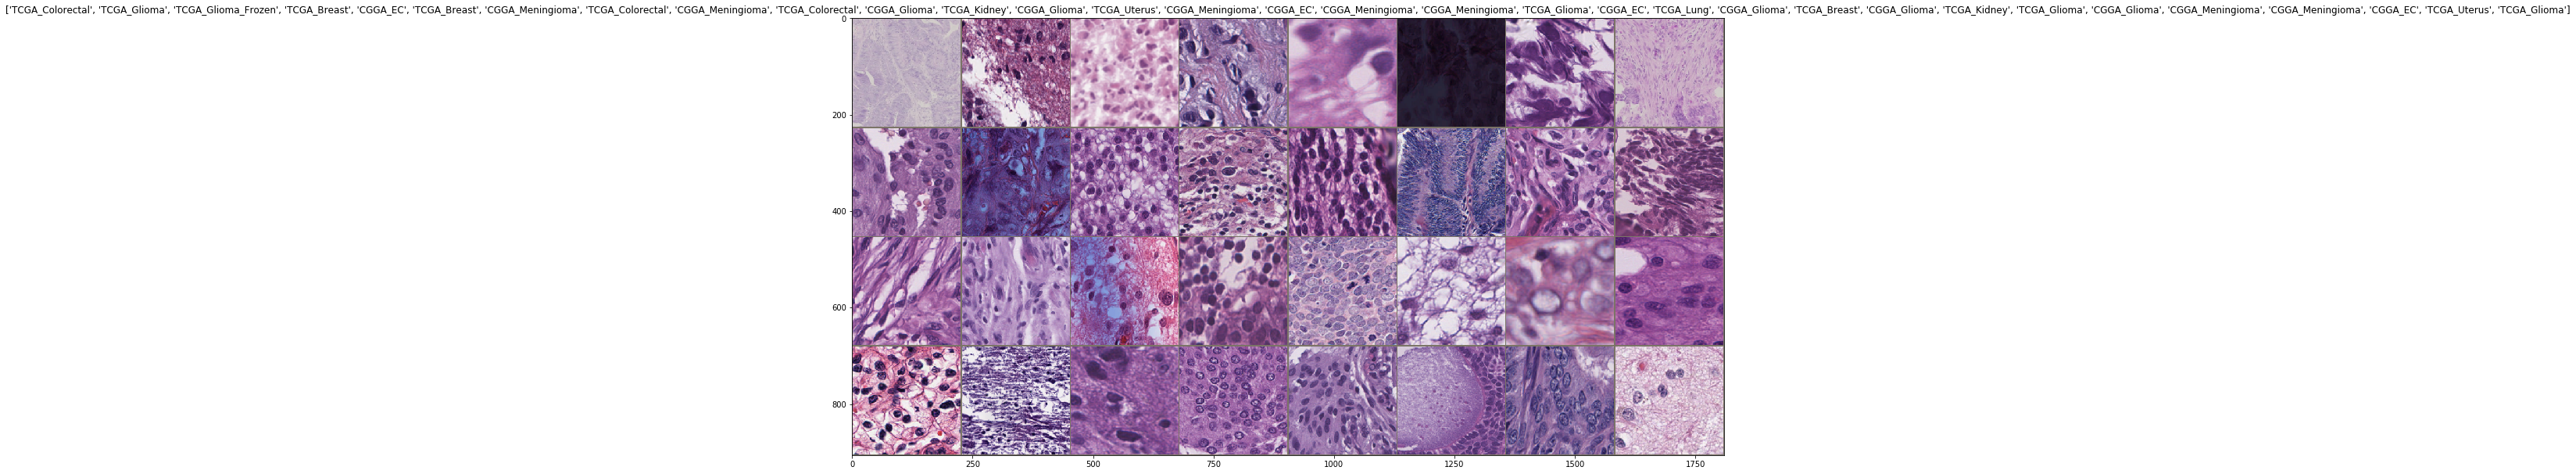

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
#                     m = nn.LogSoftmax()
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs.data, 1)
#                     loss = criterion(m(outputs), labels)
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5831 Acc: 0.7970
val Loss: 0.7471 Acc: 0.7863

Epoch 1/9
----------
train Loss: 0.2643 Acc: 0.9066
val Loss: 0.8753 Acc: 0.7660

Epoch 2/9
----------
train Loss: 0.1833 Acc: 0.9353
val Loss: 0.9395 Acc: 0.7769

Epoch 3/9
----------
train Loss: 0.1416 Acc: 0.9512
val Loss: 0.9062 Acc: 0.8064

Epoch 4/9
----------
train Loss: 0.1160 Acc: 0.9615
val Loss: 0.9995 Acc: 0.7881

Epoch 5/9
----------
train Loss: 0.1053 Acc: 0.9645
val Loss: 0.9485 Acc: 0.7913

Epoch 6/9
----------
train Loss: 0.0883 Acc: 0.9698
val Loss: 1.0394 Acc: 0.7805

Epoch 7/9
----------
train Loss: 0.0573 Acc: 0.9808
val Loss: 0.9454 Acc: 0.8013

Epoch 8/9
----------
train Loss: 0.0496 Acc: 0.9845
val Loss: 0.9687 Acc: 0.7997

Epoch 9/9
----------
train Loss: 0.0470 Acc: 0.9847
val Loss: 0.9476 Acc: 0.8040

Training complete in 70m 11s
Best val Acc: 0.806400


In [18]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

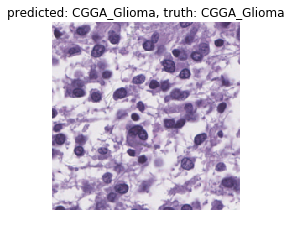

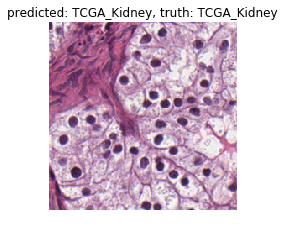

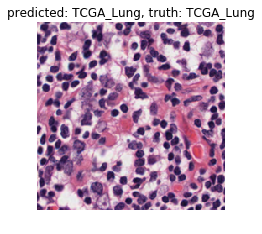

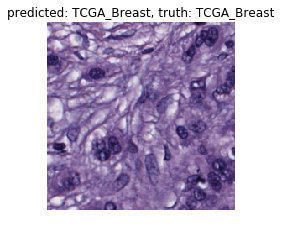

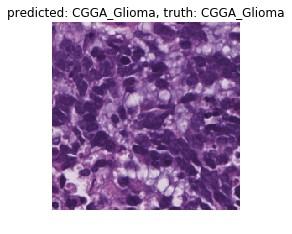

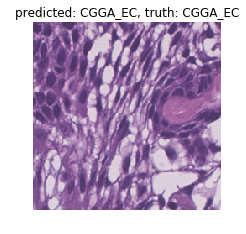

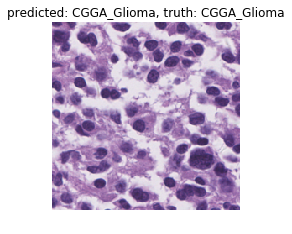

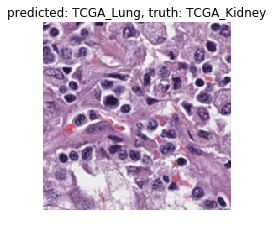

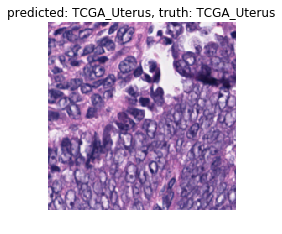

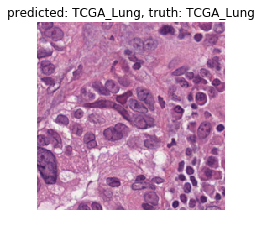

In [22]:
visualize_model(model_ft)

In [20]:
torch.save(model_ft.state_dict(), 'model_ft')

In [48]:
loader = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.to(device)  #assumes that you're using GPU

for img in glob.glob('data/unknown/*'):
    image = image_loader(img)
    imshow(image.cpu().detach().numpy())
    # model_ft.eval()
    output = model_ft(image)
    _, pred = torch.max(output, 1)
    sm = torch.nn.Softmax()
    probabilities = sm(output)
    print('\nclass name:', class_names[pred])
    prob, _ = torch.max(probabilities, 1)
    print('probability:', prob)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

# Transfer learning, last layer